# Federated Learning with SynapseMNIST3D Dataset
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/fl-tutorial/blob/gh-pages/tutorial_notebooks/solutions/Tutorial_2_Medmnist_3D_solutions.ipynb)

### Dependencies and Packages
Let's get these out of the way first.

In [1]:
!python -m pip install -U pip
!python -m pip install tqdm torch torchvision medmnist acsconv matplotlib

In [2]:
# To access example workspaces and director/envoy scripts
!rm -rf openfl
!git clone -b miccai_fl_tutorial https://github.com/intel/openfl.git
!cd openfl && python -m pip install .

Cloning into 'openfl'...
remote: Enumerating objects: 5025, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (327/327), done.
remote: Total 5025 (delta 205), reused 274 (delta 91), pack-reused 4591
Receiving objects: 100% (5025/5025), 118.37 MiB | 2.70 MiB/s, done.
Resolving deltas: 100% (2893/2893), done.
Processing /home/karan/workspace/fl-tutorial/tutorial_notebooks/solutions/openfl
  Preparing metadata (setup.py) ... done
  Created wheel for openfl: filename=openfl-1.4-py3-none-any.whl size=615343 sha256=8e97d9369730018d07a9242ddac69f29a867dd935b4c818267bec0f3398963c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-uitqipo1/wheels/41/03/ef/61d3c4dcd526cdfe9914adbbbec882bf5d06b15a84011b0a09
Successfully built openfl
  Attempting uninstall: openfl
    Found existing installation: openfl 1.4
    Uninstalling openfl-1.4:
      Successfully uninstalled openfl-1.4


### Hacks

A few duct-tape fixes to allow us to 1-click execute.

In [3]:
import os
import logging

# Better CPU Utilization
os.environ['OMP_NUM_THREADS'] = str(int(os.cpu_count() // 2))

# Logging fix for Google Colab
log = logging.getLogger()
log.setLevel(logging.INFO)

# Switch to the workspace directory
tutorial_dir = os.path.abspath(
    'openfl/openfl-tutorials/interactive_api/PyTorch_MedMNIST_3D')
os.chdir(tutorial_dir)

### Imports

In [4]:
import numpy as np
from tqdm import tqdm
from pprint import pprint

import torch
import medmnist

print('PyTorch', torch.__version__)
print('MedMNIST', medmnist.__version__)

PyTorch 1.8.2+cu111
MedMNIST 2.1.0


### Familiarize yourself with the Dataset

MedMNIST is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. MedMNIST is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label).

![Datasets in MedMNIST](https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/assets/medmnistv2.jpg)

Source: https://github.com/MedMNIST/MedMNIST

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.

### Dataset Configuration

In [5]:
# Train/test options
NUM_EPOCHS = 3
BATCH_SIZE = 16
DEVICE = 'cpu'

# Dataset
DATASET_NAME = 'synapsemnist3d'
DATASET_PATH = './data'
ds_info = medmnist.INFO[DATASET_NAME]
pprint(ds_info)

{'MD5': '1235b78a3cd6280881dd7850a78eadb6',
 'description': 'The SynapseMNIST3D is a new 3D volume dataset to classify '
                'whether a synapse is excitatory or inhibitory. It uses a 3D '
                'image volume of an adult rat acquired by a multi-beam '
                'scanning electron microscope. The original data is of the '
                'size 100×100×100um^3 and the resolution 8×8×30nm^3, where a '
                '(30um)^3 sub-volume was used in the MitoEM dataset with dense '
                '3D mitochondria instance segmentation labels. Three '
                'neuroscience experts segment a pyramidal neuron within the '
                'whole volume and proofread all the synapses on this neuron '
                'with excitatory/inhibitory labels. For each labeled synaptic '
                'location, we crop a 3D volume of 1024×1024×1024nm^3 and '
                'resize it into 28×28×28 voxels. Finally, the dataset is '
                'randomly split w

### Familiarize with the Dataset

Let's use some plotting tools here.

  0%|          | 0/38034583 [00:00<?, ?it/s]

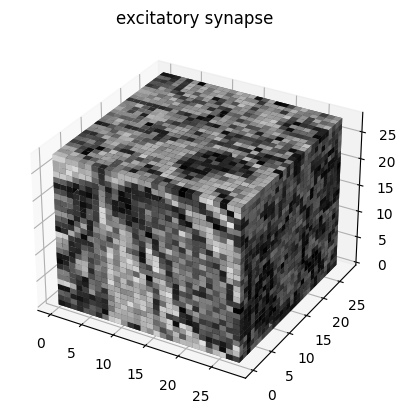

In [6]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

from envoy.medmnist_shard_descriptor import MedMNISTShardDescriptor

# Download raw numpy dataset
sd = MedMNISTShardDescriptor(datapath=DATASET_PATH, dataname=DATASET_NAME)
(x_train, y_train), (x_test, y_test) = sd.load_data()

# Visualize a sample
sample_id = 42
label2str = list(ds_info['label'].values())
volume = x_train[sample_id]
label = label2str[np.squeeze(y_train[sample_id])]

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap("gray")
norm = plt.Normalize(volume.min(), volume.max())
ax.voxels(volume, facecolors=cmap(norm(volume)))
plt.title(label)
plt.show()


### Define Dataset/Dataloader Classes

We'll create a simple PyTorch-style iterator dataset that returns single `numpy` element as a `torch.Tensor`. The class used for this would be `torch.utils.data.Dataset`

We will then wrap this dataset object with a Dataloader class, that batches and shuffles the elements. Class: `torch.utils.data.DataLoader`

### Model Definition (3D CNN)

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(16, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(16, 64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4 * 4, 128), 
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Go Federated
### Imports

In [52]:
import os
import time
import yaml
from typing import Dict, List, Union

### Configure `Director`

This is the entity that orchestrates the tasks and aggregation of models from participants. Below cells are to configure the `yaml` and start the `Director` service.

In [53]:
# Should be the same as defined in `director_config.yaml`
director_node_fqdn = 'localhost'
director_port = 50051

director_workspace_path = os.path.join(tutorial_dir, 'director')
director_config_file = os.path.join(director_workspace_path,'director_config.yaml')
director_logfile = os.path.join(director_workspace_path, 'director.log')

# Start director
os.system(f'cd {director_workspace_path};'
          f'fx director start --disable-tls -c {director_config_file} '
          f'>{director_logfile} &')
!sleep 5 && tail -n5 $director_logfile

[16:44:58] INFO     🧿 Starting the Director Service.                                                                                             director.py:50
[16:44:59] INFO     Sample shape: ['28', '28', '28'], target shape: ['1', '1']                                                                    director.py:74
           INFO     Starting server on localhost:50051                                                                                    director_server.py:114


### Configure `Envoys`

`Envoy`, for sake of simplicity, can be thought of as collaborators. Technically, `Envoy` defines the dataloading interface for each participant and runs python code (called a `task`) that it receives via this notebook.

We create as many config files as number of participants that we intend to simulate here.

In [54]:
def generate_envoy_configs(
        config: dict,
        n_cols: int,
        datapath: str,
        dataname: str,
        save_path: str) -> list:
    
    config_paths = list()
    for i in range(1, n_cols+1):
        path = os.path.abspath(os.path.join(save_path, f'{i}_envoy_config.yaml'))
        config['shard_descriptor']['params']['datapath'] = datapath
        config['shard_descriptor']['params']['dataname'] = dataname    
        config['shard_descriptor']['params']['rank_worldsize'] = f'{i},{n_cols}'
        with open(path, 'w') as f:
            yaml.safe_dump(config, f)
        config_paths.append(path)
    return config_paths

### Generate configs and start `Envoys`

In [55]:
# Read the original envoy config file content
original_config_path = os.path.join(tutorial_dir, 'envoy', 'envoy_config.yaml')
with open(original_config_path, 'r') as f:
    original_config = yaml.safe_load(f)

# Generate configs for as many envoys
config_paths = generate_envoy_configs(original_config,
                                      n_cols=2,
                                      datapath=DATASET_PATH,
                                      dataname=DATASET_NAME,
                                      save_path=os.path.dirname(original_config_path))
# Start envoys in a loop
cwd = os.getcwd()
for i, path in enumerate(config_paths):
    print(f'Starting Envoy {i+1}')
    os.chdir(os.path.dirname(path))

    # Wait until envoy loads dataset
    os.system(f'fx envoy start -n env_{i+1} --disable-tls '
                f'--envoy-config-path {path} -dh {director_node_fqdn} -dp {director_port} '
                f'2>&1 >env_{i+1}.log &')
    !grep -q "MedMNIST data was loaded" <( tail -f env_{i+1}.log )
    
    os.chdir(cwd)

Starting Envoy 1
Starting Envoy 2


### Connect this Notebook to the Infrastructure

This is where you take the seat of a Data Scientist, who bears control over the `model`, `train()`, `validate()` and other logic that `Director` and `Envoy` help you execute across participants.

In [56]:
from openfl.interface.interactive_api.federation import Federation

# Create a federation
federation = Federation(client_id='frontend',
                        director_node_fqdn=director_node_fqdn,
                        director_port=director_port,
                        tls=False)

# Wait till all envoys publish their shard registry.
pprint(federation.get_shard_registry())

{'env_1': {'current_time': '2022-09-17 16:45:07',
           'experiment_name': 'ExperimentName Mock',
           'is_experiment_running': False,
           'is_online': True,
           'last_updated': '2022-09-17 16:45:04',
           'shard_info': node_info {
  name: "env_1"
}
shard_description: "MedMNIST dataset, shard number 1 out of 2"
sample_shape: "28"
sample_shape: "28"
sample_shape: "28"
target_shape: "1"
target_shape: "1"
,
           'valid_duration': seconds: 120
},
 'env_2': {'current_time': '2022-09-17 16:45:07',
           'experiment_name': 'ExperimentName Mock',
           'is_experiment_running': False,
           'is_online': True,
           'last_updated': '2022-09-17 16:45:07',
           'shard_info': node_info {
  name: "env_2"
}
shard_description: "MedMNIST dataset, shard number 2 out of 2"
sample_shape: "28"
sample_shape: "28"
sample_shape: "28"
target_shape: "1"
target_shape: "1"
,
           'valid_duration': seconds: 120
}}


### Ingredients of a Federated Learning Experiment in OpenFL

* `DataInterface`: This class defines the dataloading primitives for OpenFL. We'll reuse some of our previous logic.
* `ModelInterface`: Registers model graph and optimizer; serializes them and sends them to collaborator nodes.
* `TaskInterface`: Registers the python methods that constitute each task like `training`, `validation` etc.

In [57]:
from openfl.interface.interactive_api.experiment import DataInterface

# A fix to access the following module
os.chdir(os.path.join(tutorial_dir, 'workspace'))
from wspace_utils.utils import Transform3D

class TransformDataset(Dataset):
    """Applies transforms to each element of the Dataset"""

    def __init__(self, dataset, transform=None, target_transform=None):
        """Initializes Dataset"""
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """Returns length of the dataset"""
        return len(self.dataset)

    def __getitem__(self, index):
        """Returns img, label by index, with transforms if any"""
        img, label = self.dataset[index]
        img = np.stack([img/255.], axis=0)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        if self.transform:
            img = self.transform(img)

        return img, label

# Transforms
shape_transform = False
train_transform = Transform3D(mul='random') if shape_transform else Transform3D()
eval_transform = Transform3D(mul='0.5') if shape_transform else Transform3D()

class MedMnistFedDataset(DataInterface):

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    @property
    def shard_descriptor(self):
        return self._shard_descriptor

    @shard_descriptor.setter
    def shard_descriptor(self, shard_descriptor):
        """
        Describe per-collaborator procedures or sharding.

        This method will be called during a collaborator initialization.
        Local shard_descriptor  will be set by Envoy.
        """
        self._shard_descriptor = shard_descriptor

        self.train_set = TransformDataset(
            self._shard_descriptor.get_dataset('train'),
            transform=train_transform)

        self.valid_set = TransformDataset(
            self._shard_descriptor.get_dataset('val'),
            transform=eval_transform)

    def get_train_loader(self, **kwargs):
        """Output of this method will be provided to tasks with optimizer in contract"""
        return DataLoader(self.train_set,
                          num_workers=8,
                          batch_size=self.kwargs['train_bs'],
                          shuffle=True)

    def get_valid_loader(self, **kwargs):
        """Output of this method will be provided to tasks without optimizer in contract"""
        return DataLoader(self.valid_set,
                          num_workers=8,
                          batch_size=self.kwargs['valid_bs'])

    def get_train_data_size(self):
        """Information for aggregation"""
        return len(self.train_set)

    def get_valid_data_size(self):
        """Information for aggregation"""
        return len(self.valid_set)


In [58]:
fed_dataset = MedMnistFedDataset(train_bs=BATCH_SIZE, valid_bs=BATCH_SIZE)

### `ModelInterface`

In [59]:
from openfl.interface.interactive_api.experiment import ModelInterface

from acsconv.converters import Conv3dConverter
from wspace_utils.utils import model_to_syncbn

def get_3d_cnn():
  ## Fill: Instantiate a model
  model = Net(in_channels=ds_info['n_channels'], num_classes=len(ds_info['label'].values()))

  ## Fill: Convert model to 3D using Conv3dConverter
  model = Conv3dConverter(model, i3d_repeat_axis=None)

  ## Fill: Convert all BatchNorm layers to SyncBN layers
  model = model_to_syncbn(model)
  return model

model = get_3d_cnn()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  ## Fill: Instantiate an `Adam` Optimizer
criterion = nn.CrossEntropyLoss()  ## Fill: Instantiate a CrossEntropyLoss function

framework_adapter = 'openfl.plugins.frameworks_adapters.pytorch_adapter.FrameworkAdapterPlugin'
MI = ModelInterface(model=model.model,
                    optimizer=optimizer,
                    framework_plugin=framework_adapter)


### `TaskInterface`
We register our tasks with a `TaskInterface` class.
OpenFL decides which model is the best based on an *increasing* metric.

In [60]:
from openfl.interface.interactive_api.experiment import TaskInterface

# Task interface currently supports only standalone functions.
TI = TaskInterface()
extra_args = {'criterion': criterion}

# Train task
@TI.add_kwargs(**extra_args)
@TI.register_fl_task(model='model', data_loader='data_loader', device='device', optimizer='optimizer')
def train(model: nn.Module, 
          data_loader: torch.utils.data.DataLoader,
          device: str,
          optimizer: torch.optim.Optimizer, 
          criterion: nn.Module) -> dict:
    """Trains `model` for 1 epoch on `train_loader`

    Args:
        model (nn.Module): PyTorch Model.
        dataloader (torch.utils.data.DataLoader): Training Dataloader.
        optimizer (torch.optim.Optimizer): Optimizer instance.
        criterion (nn.Module): Loss function instance.

    Returns:
        dict: `acc` and `loss` metrics over the dataloader
    """
    ## Set the model to training mode
    model.train()

    ## Initialize counters for accuracy/loss
    losses = []
    correct = 0
    total = 0

    ## Create a `for` loop that iterates over the dataloader
    for x, y in tqdm(data_loader, desc='training'):
        ## Push `x` and `y` tensors to the device
        x = x.to(device)
        y = torch.squeeze(y).long().to(device)
        
        ## Clear optimizer gradients
        optimizer.zero_grad()
        
        ## Forward pass `x` through the model to get `preds`
        preds = model(x)
        
        ## Calculate `loss` using the criterion
        loss = criterion(preds, y)

        ## Backpropagate `loss` to compute gradients
        loss.backward()
        
        ## Apply gradients with step
        optimizer.step()
        
        ## Record metrics
        losses.append(loss.item())
        correct += torch.sum(preds.max(1)[1] == y).item()
        total += y.size(0)

    #############################################################
    return {
        'train_acc': np.round(correct/total, 3),
        'train_loss': np.round(np.mean(losses), 3),
    }

@TI.add_kwargs(**extra_args)
@TI.register_fl_task(model='model', data_loader='data_loader', device='device')
def validate(model: nn.Module, 
             data_loader: torch.utils.data.DataLoader,
             device: str,
             criterion: nn.Module) -> dict:
    """Computes `acc` and `loss` of the `model` on `val_loader`

    Args:
        model (nn.Module): PyTorch Model.
        data_loader (torch.utils.data.DataLoader): Validation Dataloader.
        device (str): 'cpu' or 'cuda'
        criterion (nn.Module): Loss function instance.

    Returns:
        dict: `acc` and `loss` metrics over the dataloader
    """
    ## Set the model to evaluation mode
    model.eval()

    ## Initialize counters for accuracy/loss
    losses = []
    correct = 0
    total = 0

    ## Define a scope that disables gradient calculation
    with torch.no_grad():
        ## Create a `for` loop that iterates over the dataloader
        for x, y in tqdm(data_loader, desc='validating'):
            ## Push `x` and `y` tensors to the device
            x = x.to(device)
            y = torch.squeeze(y).long().to(device)
            
            ## Forward pass `x` through the model to get `preds`
            preds = model(x)
            
            ## Calculate `loss` using the criterion
            loss = criterion(preds, y)
            
            ## Record metrics
            losses.append(loss.item())
            correct += torch.sum(preds.max(1)[1] == y).item()
            total += y.size(0)

    #############################################################

    return {
        'val_acc': np.round(correct/total, 3),
        'val_loss': np.round(np.mean(losses), 3),
    }

### Run the Experiment

In [61]:
from openfl.interface.interactive_api.experiment import FLExperiment

fl_experiment = FLExperiment(federation=federation, experiment_name='synapsemnist3d_experiment')
fl_experiment.start(model_provider=MI,
                    task_keeper=TI,
                    data_loader=fed_dataset,
                    rounds_to_train=3,
                    device_assignment_policy='CUDA_PREFERRED')

# This method streams logs from the director, and also saves logs in the tensorboard format (by default)
fl_experiment.stream_metrics()

[16:45:08] INFO     Building 🡆 Object CloudpickleSerializer from openfl.plugins.interface_serializer.cloudpickle_serializer Module.                  ]8;id=638855;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=643304;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

           INFO     Building 🡆 Object FrameworkAdapterPlugin from openfl.plugins.frameworks_adapters.pytorch_adapter Module.                         ]8;id=142494;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=771139;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

[16:45:09] INFO     Starting experiment!                                                                                                       ]8;id=308280;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=479831;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#232\232]8;;\

           INFO     FL-Plan hash is 27591f501077d830429fb98552ec6e23b921f54c2ad47f6b81f718025dfb4918c2961ef1ee31bd9d84c9d5d256c962f0                 ]8;id=428003;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=815633;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py#237\237]8;;\

           INFO     FL-Plan hash is 27591f501077d830429fb98552ec6e23b921f54c2ad47f6b81f718025dfb4918c2961ef1ee31bd9d84c9d5d256c962f0                 ]8;id=252920;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=733489;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py#237\237]8;;\

           INFO     Building 🡆 Object CoreTaskRunner from openfl.federated.task.task_runner Module.                                                  ]8;id=869260;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=950383;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

           INFO     Building 🡆 Object FrameworkAdapterPlugin from openfl.plugins.frameworks_adapters.pytorch_adapter Module.                         ]8;id=448623;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=578276;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

           WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=33786;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/utilities/utils.py\utils.py]8;;\:]8;id=84034;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/utilities/utils.py#170\170]8;;\

           WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=392212;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/utilities/utils.py\utils.py]8;;\:]8;id=697157;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/utilities/utils.py#170\170]8;;\

           INFO     SetNewExperiment                                                                                                      ]8;id=363874;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/transport/grpc/director_client.py\director_client.py]8;;\:]8;id=901812;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/transport/grpc/director_client.py#202\202]8;;\

           INFO     Experiment was accepted and launched.                                                                                      ]8;id=591297;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=418350;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#246\246]8;;\

/home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/plugins/frameworks_adapters/pytorch_adapter.py:47: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  new_state[k] = pt.from_numpy(tensor_dict.pop(k)).to(device)
training:   0%|          | 0/39 [00:00<?, ?it/s]/home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/plugins/frameworks_adapters/pytorch_adapter.py:47: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array usi

[16:45:50] METRIC   Round 0, collaborator trained train result train_acc:   0.681000                                                           ]8;id=366627;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=674250;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator trained train result train_loss:  0.665000                                                           ]8;id=999911;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=932526;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator trained train result train_acc:   0.689000                                                           ]8;id=381189;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=724337;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator trained train result train_loss:  0.653000                                                           ]8;id=158153;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=238786;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating:   9%|▉         | 1/11 [00:00<00:04,  2.29it/s]

[16:45:53] METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_acc:       0.727000                           ]8;id=738887;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=232609;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_loss:      0.607000                           ]8;id=261670;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=544492;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_acc:       0.733000                           ]8;id=493286;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=934615;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_loss:      0.590000                           ]8;id=700047;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=357859;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating:  91%|█████████ | 10/11 [00:02<00:00,  5.57it/s]

[16:45:55] METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_acc:    0.727000                                   ]8;id=729232;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=20983;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_loss:   0.676000                                   ]8;id=259393;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=41321;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating: 100%|██████████| 11/11 [00:02<00:00,  4.60it/s]


[16:45:56] METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_acc:    0.733000                                   ]8;id=933583;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=107805;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_loss:   0.676000                                   ]8;id=494236;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=564477;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

training:   0%|          | 0/39 [00:00<?, ?it/s]

[16:45:58] METRIC   Round 0, collaborator Aggregator train result train_acc:        0.685000                                                   ]8;id=743982;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=577132;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator train result train_loss:       0.659000                                                   ]8;id=738329;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=124010;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.730000                                   ]8;id=559010;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=584125;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator locally_tuned_model_validate result val_loss:  0.598500                                   ]8;id=967586;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=385875;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator aggregated_model_validate result val_acc:      0.730000                                   ]8;id=892877;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=742330;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator aggregated_model_validate result val_loss:     0.676000                                   ]8;id=590024;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=730894;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating:   0%|          | 0/11 [00:00<?, ?it/s]89it/s]

[16:46:17] METRIC   Round 1, collaborator trained train result train_acc:   0.735000                                                           ]8;id=486686;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=110215;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator trained train result train_loss:  0.564000                                                           ]8;id=588206;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=804528;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

training:  59%|█████▉    | 23/39 [00:13<00:09,  1.76it/s]

[16:46:20] METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_acc:       0.739000                           ]8;id=512504;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=734648;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_loss:      0.562000                           ]8;id=373497;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=146045;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]


[16:46:22] METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_acc:    0.733000                                   ]8;id=780615;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=258947;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_loss:   0.648000                                   ]8;id=944368;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=554232;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating:   9%|▉         | 1/11 [00:00<00:02,  3.69it/s]

[16:46:27] METRIC   Round 1, collaborator trained train result train_acc:   0.730000                                                           ]8;id=500788;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=864498;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator trained train result train_loss:  0.575000                                                           ]8;id=334865;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=530896;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating:  45%|████▌     | 5/11 [00:00<00:00,  7.42it/s]

[16:46:29] METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_acc:       0.727000                           ]8;id=202706;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=694964;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_loss:      0.596000                           ]8;id=563182;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=505126;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating: 100%|██████████| 11/11 [00:01<00:00,  6.87it/s]


[16:46:30] METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_acc:    0.722000                                   ]8;id=455270;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=591966;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_loss:   0.646000                                   ]8;id=289036;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=978830;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[16:46:32] METRIC   Round 1, collaborator Aggregator train result train_acc:        0.732500                                                   ]8;id=571544;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=252302;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator train result train_loss:       0.569500                                                   ]8;id=85775;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=155552;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.733000                                   ]8;id=48579;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=323027;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator locally_tuned_model_validate result val_loss:  0.579000                                   ]8;id=848272;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=829906;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator aggregated_model_validate result val_acc:      0.727500                                   ]8;id=221725;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=721853;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator aggregated_model_validate result val_loss:     0.647000                                   ]8;id=332304;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=181159;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating:   0%|          | 0/11 [00:00<?, ?it/s]93it/s]

[16:46:51] METRIC   Round 2, collaborator trained train result train_acc:   0.735000                                                           ]8;id=302123;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=940057;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator trained train result train_loss:  0.538000                                                           ]8;id=19458;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=840318;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

training:  41%|████      | 16/39 [00:11<00:16,  1.36it/s]

[16:46:54] METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_acc:       0.727000                           ]8;id=431127;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=735198;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_loss:      0.578000                           ]8;id=718078;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=81463;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

training:  51%|█████▏    | 20/39 [00:14<00:14,  1.34it/s]

[16:46:57] METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_acc:    0.733000                                   ]8;id=683563;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=360570;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_loss:   0.584000                                   ]8;id=458576;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=291586;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating:  64%|██████▎   | 7/11 [00:00<00:00,  8.33it/s]

[16:47:05] METRIC   Round 2, collaborator trained train result train_acc:   0.741000                                                           ]8;id=861170;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=428459;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator trained train result train_loss:  0.539000                                                           ]8;id=519680;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=222228;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating:   0%|          | 0/11 [00:00<?, ?it/s]

[16:47:06] METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_acc:       0.733000                           ]8;id=216691;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=964958;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_loss:      0.556000                           ]8;id=716142;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=779767;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validating: 100%|██████████| 11/11 [00:02<00:00,  5.00it/s]


[16:47:08] METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_acc:    0.733000                                   ]8;id=548097;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=453263;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_loss:   0.567000                                   ]8;id=650280;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=517585;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[16:47:11] METRIC   Round 2, collaborator Aggregator train result train_acc:        0.738000                                                   ]8;id=500698;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=39827;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator train result train_loss:       0.538500                                                   ]8;id=959961;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=156941;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.730000                                   ]8;id=557794;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=38601;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator locally_tuned_model_validate result val_loss:  0.567000                                   ]8;id=879376;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=476712;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator aggregated_model_validate result val_acc:      0.733000                                   ]8;id=316866;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=530268;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator aggregated_model_validate result val_loss:     0.575500                                   ]8;id=395304;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=257434;file:///home/karan/workspace/fl-tutorial/venv/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

## Cleanup

In [62]:
# To stop all services run
!pkill fx
[os.remove(path) for path in config_paths]

[None, None]